Generate measurements


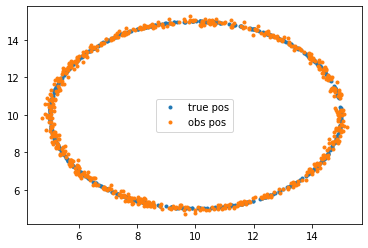

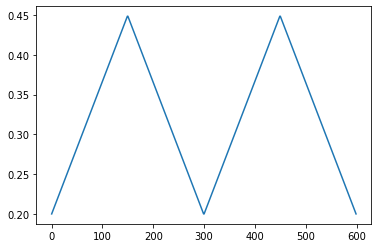

In [13]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# number of epochs
N=600

t=np.arange(1,N+1)

obsnoise=0.1

# true values
x_true=10
y_true=10
r_true = 5
batch = 0.2+0.1/60.0*np.concatenate((np.arange(0,N/4),np.arange(N/4-1,-1,-1)),axis=None)
omega_true = np.concatenate((batch,batch),axis=None)
#omega_true = np.ones(N)*0.2

obsx_true = x_true+r_true * np.cos(omega_true*t)
obsy_true = y_true+r_true * np.sin(omega_true*t)

obsx = obsx_true + obsnoise*np.random.normal(0, 1, N)
obsy = obsy_true + obsnoise*np.random.normal(0, 1, N)
plt.plot(obsx_true,obsy_true,'.',label='true pos')
plt.plot(obsx,obsy,'.',label='obs pos')
plt.legend()
plt.figure()

plt.plot(np.arange(0,N),omega_true,label='true omega')


In [14]:


def Phi(dt):
    return np.matrix([[1, 0, 0, 0 , 0], [0, 1, 0,0, 0], [0, 0, 1, 0, 0], [0,0,0,1, dt],[0, 0, 0, 0, 1] ])    

def Q(sigma,dt):
    return sigma*sigma*np.matrix( [[0, 0 ,0 ,0, 0], \
                                   [0, 0 ,0 ,0, 0], \
                                   [0, 0 ,0 ,0, 0], \
                                   [0, 0 ,0 ,dt**3/3.0, dt**2/2.0], \
                                   [0, 0 ,0 ,dt**2/2.0, dt]])   

def H_lin(state,t):
    return np.matrix([[ 1, 0 , np.cos(state[3,0]*t) ,  -state[2,0]*t*np.sin(state[3,0]*t) , 0 ], \
                      [ 0, 1 , np.sin(state[3,0]*t) ,   state[2,0]*t*np.cos(state[3,0]*t), 0 ]]) 
def z_model(state,t):
    return np.matrix([[ state[0,0]+state[2,0] * np.cos(state[3,0]*t)], \
                      [ state[1,0]+state[2,0] * np.sin(state[3,0]*t)]]) 



In the forward run we get

In [15]:
#start with a random state
xnn=np.array([[10+np.random.randn()*0.1],\
             [10+ np.random.randn()*0.1],\
             [5+np.random.randn()*0.1],\
             [0.2],[0]])
#since we don't know much about our state we make its covariance pretty large
Pnn=np.eye(5,5)*1


x_sol=[]
P_sol=[]
sigma=0.001

for i in np.arange(0,N):
    #predict state
    ph=Phi(1)
    xnn_p=ph@xnn
    

    #predict variance
    qq=Q(sigma,1)
    Pnn_p = ph@Pnn@np.transpose(ph)+qq
    
    # get the "observations" 
    z=np.array([[obsx[i]],[obsy[i]]])
    # build the H matrix
    H=H_lin(xnn_p,i) 
    # covariance of the observations
    R=np.eye(2,2)*obsnoise**2
    # compute Kalman gain

    K=Pnn_p@np.transpose(H)@inv(H@Pnn_p@np.transpose(H)+R)    
    #update the state
    xnn=xnn_p + K@(z-z_model(xnn_p,i))
    

    
    #update the covariance
    Pnn=(np.eye(xnn.size)-K@H)@Pnn_p
    
    #save the results
    x_sol.append(xnn)
    P_sol.append(Pnn)

    


Make data for plot

In [16]:
#some book keeping for later plotting
x_array=np.zeros(N) 
y_array=np.zeros(N)
r_array=np.zeros(N)
w_array=np.zeros(N)
sigmax=np.zeros(N) 
sigmay=np.zeros(N) 
sigmar=np.zeros(N) 
sigmaw=np.zeros(N)

for i in np.arange(0,N):
    P = P_sol[i]
    x= x_sol[i]     
    x_array[i]=x[0,0]
    y_array[i]=x[1,0] 
    r_array[i]=x[2,0]
    w_array[i]=x[3,0]
    sigmax[i]=np.sqrt(P[0,0])
    sigmay[i]=np.sqrt(P[1,1])
    sigmar[i]=np.sqrt(P[2,2])
    sigmaw[i]=np.sqrt(P[3,3])
    

Let's plot what we just did!!!

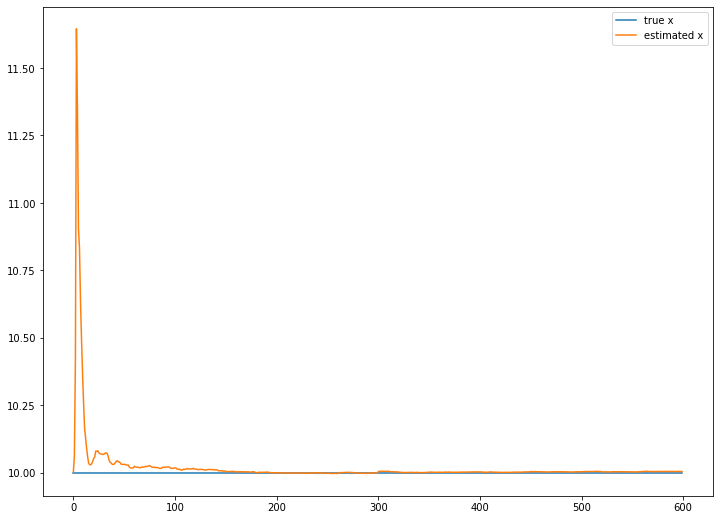

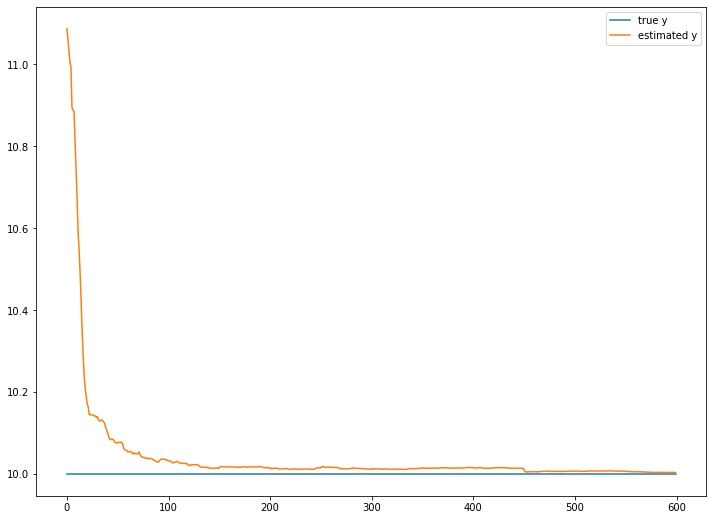

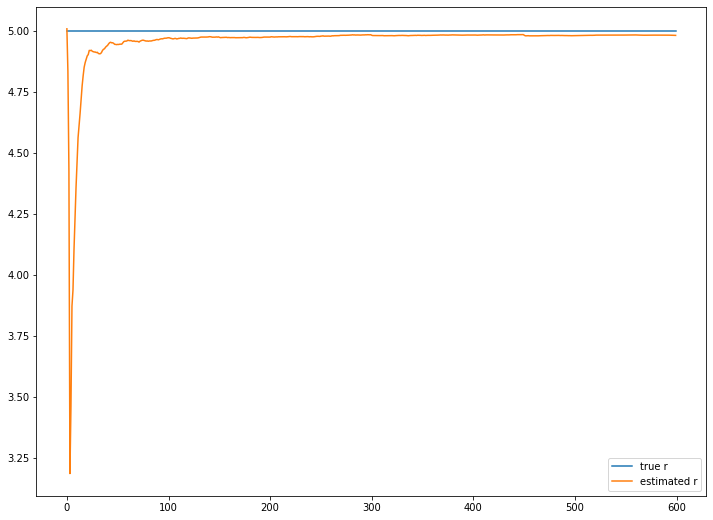

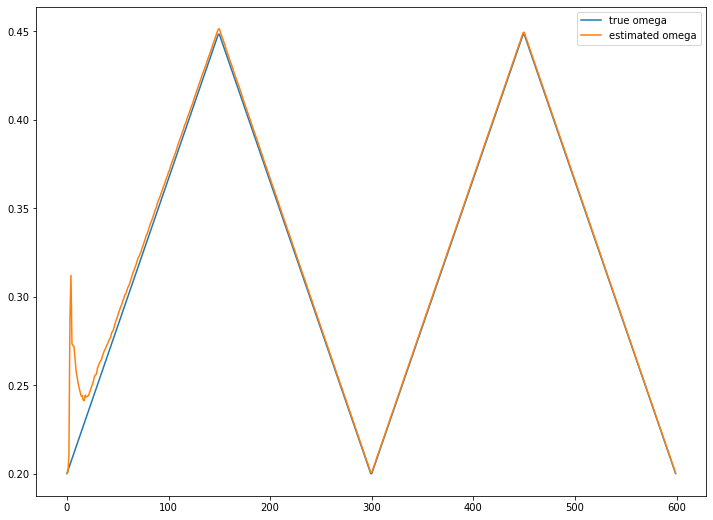

In [17]:
plt.figure(1,figsize=(12, 9))
plt.plot(np.arange(0,N), np.ones(N)* x_true,label='true x')
plt.plot(np.arange(0,N), x_array, label='estimated x')
plt.legend()
plt.show()

plt.figure(2,figsize=(12, 9))
plt.plot(np.arange(0,N), np.ones(N)* y_true,label='true y')
plt.plot(np.arange(0,N), y_array, label='estimated y')
plt.legend()
plt.show()
    
plt.figure(3,figsize=(12, 9))
plt.plot(np.arange(0,N), np.ones(N)* r_true,label='true r')
plt.plot(np.arange(0,N), r_array, label='estimated r')
plt.legend()
plt.show()    

plt.figure(4,figsize=(12, 9))
plt.plot(np.arange(0,N), omega_true,label='true omega')
plt.plot(np.arange(0,N), w_array, label='estimated omega')
plt.legend()
plt.show()

    

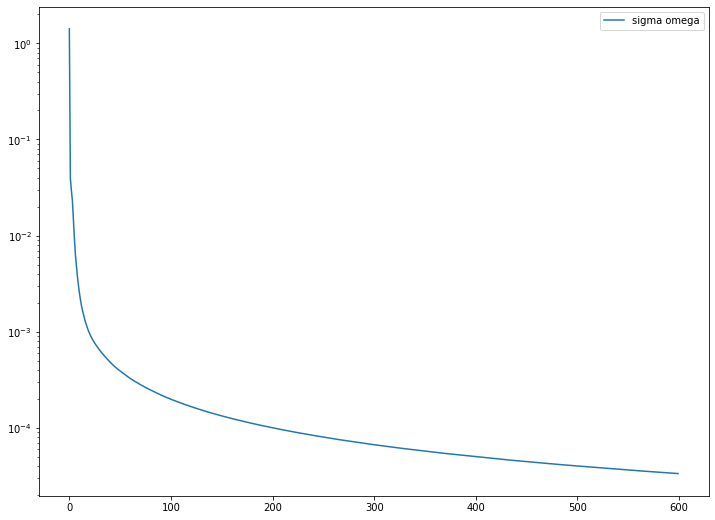

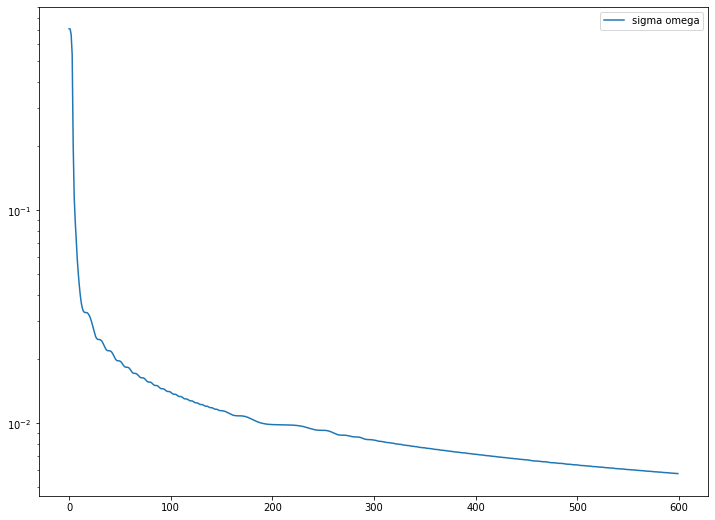

In [18]:
plt.figure(5,figsize=(12, 9))
plt.semilogy(np.arange(0,N), sigmaw,label='sigma omega')
plt.legend()
plt.show()

plt.figure(6,figsize=(12, 9))
plt.semilogy(np.arange(0,N), sigmax,label='sigma omega')
plt.legend()
plt.show()